# Assignment 2: Abnormality Detection in bone X-Rays

## Name: Thomas Saltos

## Setup

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, \
  Activation, BatchNormalization, GlobalMaxPool2D, Input, TimeDistributed, LSTM, \
  GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
from PIL import Image
import keras
import cv2

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!wget https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip&h=8a19c68b1f588cf524e147a7e4507d5a5a31b0cb269f1efc5994904f1a9f8537&v=1&xid=02a1946207&uid=55365305&pool=contact_facing&subject=MURA-v1.1%3A+Link+To+Dataset

--2021-04-04 14:14:39--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  14.0MB/s    in 3m 57s  

2021-04-04 14:18:37 (13.6 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]



In [ ]:
!cp "MURA-v1.1.zip" "/content/gdrive/MyDrive"

In [ ]:
!cp "/content/gdrive/MyDrive/MURA-v1.1.zip" "/content/"

In [ ]:
%%capture
!unzip MURA-v1.1.zip

In [ ]:
!nvidia-smi

Wed Apr 14 09:35:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Exploration

* Load image paths from `train_image_paths.csv` and `valid_image_paths.csv`
* Load labels from `train_labeled_studies.csv` and `valid_labeled_studies.csv`
* Add study path to dataframe with image paths.
* Groupby path to get a list of images from a study.
* Merge image paths and labels to get a final dataframe for the task.
* The images for each study are dublicated in order to have the same number of images in all studies.
* After a search in the dataset I decide to have 6 images for each study.
* Finally, display some images.

In [ ]:
train_image_paths = pd.read_csv('MURA-v1.1/train_image_paths.csv', header=None, names=['path'])
val_image_paths = pd.read_csv('MURA-v1.1/valid_image_paths.csv', header=None, names=['path'])
train_image_paths

,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...


In [ ]:
train_labels = pd.read_csv('MURA-v1.1/train_labeled_studies.csv', header=None, names=['path', 'label'])
val_labels = pd.read_csv('MURA-v1.1/valid_labeled_studies.csv', header=None, names=['path', 'label'])
train_labels

,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1
...,...,...
13452,MURA-v1.1/train/XR_HAND/patient11180/study1_ne...,0
13453,MURA-v1.1/train/XR_HAND/patient11181/study1_ne...,0
13454,MURA-v1.1/train/XR_HAND/patient11182/study1_ne...,0
13455,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,0


In [ ]:
def add_path(p):
    return p.split('image')[0]

train_image_paths.rename(columns = {'path':'image_path'}, inplace = True)
val_image_paths.rename(columns = {'path':'image_path'}, inplace = True)

train_image_paths["path"]=train_image_paths["image_path"].apply(add_path)
val_image_paths["path"]=val_image_paths["image_path"].apply(add_path)

train_image_paths.head()

,image_path,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [ ]:
train_image_paths = train_image_paths.groupby('path')['image_path'].apply(list).reset_index()
val_image_paths = val_image_paths.groupby('path')['image_path'].apply(list).reset_index()
train_image_paths.rename(columns = {'image_path':'images'}, inplace = True)
val_image_paths.rename(columns = {'image_path':'images'}, inplace = True)
train_image_paths

,path,images
0,MURA-v1.1/train/XR_ELBOW/patient00011/study1_n...,[MURA-v1.1/train/XR_ELBOW/patient00011/study1_...
1,MURA-v1.1/train/XR_ELBOW/patient00016/study1_p...,[MURA-v1.1/train/XR_ELBOW/patient00016/study1_...
2,MURA-v1.1/train/XR_ELBOW/patient00026/study1_n...,[MURA-v1.1/train/XR_ELBOW/patient00026/study1_...
3,MURA-v1.1/train/XR_ELBOW/patient00031/study1_n...,[MURA-v1.1/train/XR_ELBOW/patient00031/study1_...
4,MURA-v1.1/train/XR_ELBOW/patient00034/study1_p...,[MURA-v1.1/train/XR_ELBOW/patient00034/study1_...
...,...,...
13452,MURA-v1.1/train/XR_WRIST/patient09078/study1_n...,[MURA-v1.1/train/XR_WRIST/patient09078/study1_...
13453,MURA-v1.1/train/XR_WRIST/patient09079/study1_n...,[MURA-v1.1/train/XR_WRIST/patient09079/study1_...
13454,MURA-v1.1/train/XR_WRIST/patient09080/study1_n...,[MURA-v1.1/train/XR_WRIST/patient09080/study1_...
13455,MURA-v1.1/train/XR_WRIST/patient09081/study1_n...,[MURA-v1.1/train/XR_WRIST/patient09081/study1_...


In [ ]:
train_df = pd.merge(train_image_paths, train_labels, on='path', how='left', suffixes=('_im_p', '_lbl_p'))
valid_df = pd.merge(val_image_paths, val_labels, on='path', how='left', suffixes=('_im_p', '_lbl_p'))
train_df.drop('path', axis=1, inplace=True)
valid_df.drop('path', axis=1, inplace=True)
train_df

,images,label
0,[MURA-v1.1/train/XR_ELBOW/patient00011/study1_...,0
1,[MURA-v1.1/train/XR_ELBOW/patient00016/study1_...,1
2,[MURA-v1.1/train/XR_ELBOW/patient00026/study1_...,0
3,[MURA-v1.1/train/XR_ELBOW/patient00031/study1_...,0
4,[MURA-v1.1/train/XR_ELBOW/patient00034/study1_...,1
...,...,...
13452,[MURA-v1.1/train/XR_WRIST/patient09078/study1_...,0
13453,[MURA-v1.1/train/XR_WRIST/patient09079/study1_...,0
13454,[MURA-v1.1/train/XR_WRIST/patient09080/study1_...,0
13455,[MURA-v1.1/train/XR_WRIST/patient09081/study1_...,0


In [ ]:
from itertools import cycle

def dublicate_images(imlist):
  if len(imlist)<6:
    myiter = cycle(imlist)
    imlist = [next(myiter) for _ in range(6)]
  return imlist

train_df["images"]=train_df["images"].apply(dublicate_images)
valid_df["images"]=valid_df["images"].apply(dublicate_images)

In [ ]:
train_df.isnull().any()

images    False
label     False
dtype: bool

In [ ]:
valid_df.isnull().any()

images    False
label     False
dtype: bool

In [ ]:
def display_images(rows, cols, df):
    """
    Plot first image foreach study
    
    params:
    rows: number of rows to plot
    cols: number of columns to plot
    df: input dataframe
    """
    plt.figure(figsize=(10,10))
    for i in range(len(df)):
        try:
            p = df['images'][i][0]
            image = mpimg.imread(p)
            plt.subplot(rows, cols, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(image, cmap=plt.cm.binary)
            filename = p.split("/")[3]
            label = df['label'][i]
            
            plt.xlabel(filename + "\n" + "label: " + str(label))
        except FileNotFoundError:
            pass

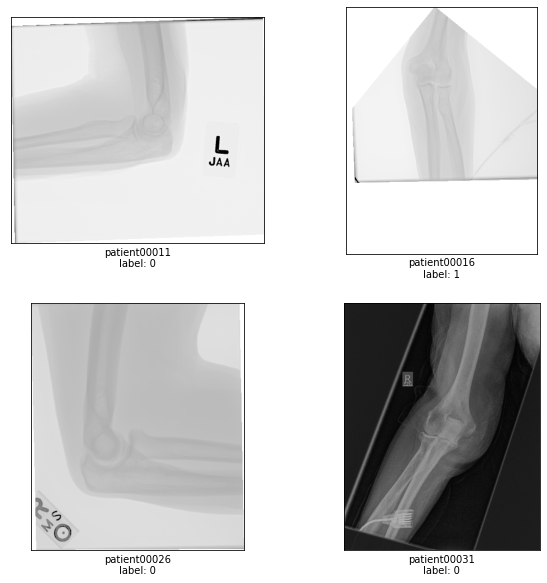

In [ ]:
display_images(rows=2, cols=2, df=train_df[:4])

## Data Preprocessing

* Split train dataset in training (80%) and validation (20%) and use validation dataset for testing perpuses.
* Create custom generator to load dataset in batches and resize images to 96x96.
* Each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer. 

In [ ]:
def train_test_split(df, test_size=0.2, random_state=1):
  train=df.sample(frac=1-test_size, random_state=200) 
  test=df.drop(train.index)
  return train, test

train_set, validation_set = train_test_split(train_df, test_size=0.2)
print("Length of train set: {}".format(len(train_set)))
print("Length of validation set: {}".format(len(validation_set)))

Length of train set: 10766
Length of validation set: 2691


In [ ]:
from sklearn.utils import shuffle
def data_generator(data, batch_size=10, shuffle_data=True, resize=(224,224)):              
    """
    Yields the next training batch.
    data is an array  [[[file1,file2,…,file6],label1], [file1,file2,…,file6],label2],……….].
    """
    num_samples = len(data)
    if shuffle_data:
        data = shuffle(data)
    while True:   
        for offset in range(0, num_samples, batch_size): 
            # Get the samples you'll use in this batch
            batch_samples = np.asarray(data[offset:offset+batch_size])
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            
            # For each example
            for batch_sample in batch_samples:
                # Load list of images (X)
                x = batch_sample[0]
                # Read label (y)
                y = batch_sample[1]
                temp_data_list = []
                c=0
                for img in x:
                    try:
                        #load until 6 image in sequence
                        c += 1
                        if c > 6:
                          break
                        img = cv2.imread(img)
                        #resize image
                        img = cv2.resize(img,resize)
                        temp_data_list.append(img)
                    except Exception as e:
                        print (e)
                        print ('error reading file: ',img)                      
                # Add example to arrays
                X_train.append(temp_data_list)
                y_train.append(y)
    
            # Make list numpy array
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            # create one hot encoding for training in keras
            #y_train = keras.utils.to_categorical(y_train, 2)
    
            # yield the next training batch            
            yield X_train, y_train

In [ ]:
train_generator = data_generator(train_set, batch_size=64, shuffle_data=True, resize=(96,96))
valid_generator = data_generator(validation_set, batch_size=64, shuffle_data=True, resize=(96,96))
# test data
test_generator = data_generator(valid_df, batch_size=64, shuffle_data=False, resize=(96,96))

In [ ]:
batch_size = 64
epochs = 30
IMG_HEIGHT = 96
IMG_WIDTH = 96

## Build a CNN from scratch

* create a cnn with input (96, 96, 3) and GlobalMaxPool2D as final layer
* create model for the study classification with TimeDistributed layer.
* add a GRU(64) cell
* a dense layer with 512 units and a dense layer with 1 output.

In [ ]:
def build_cnn(shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(GlobalMaxPool2D())
    return model

In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
def study_model(shape=(6, IMG_HEIGHT, IMG_WIDTH, 3), nbout=1):
    # Create cnn with (96, 96, 3) input shape
    convnet = build_cnn(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the cnn with (6, 96, 96, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision for the study
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

In [ ]:
model = study_model()
model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

if not os.path.exists('/content/gdrive/My Drive/checkpoints'):
    os.makedirs('/content/gdrive/My Drive/checkpoints')

checkpoint = ModelCheckpoint('/content/gdrive/My Drive/checkpoints/model_cnn_1.hdf5',
                             monitor='val_loss', 
                             mode='min', verbose=2,
                             save_best_only=True,
                             save_weights_only=True)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 6, 512)            4689216   
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                110976    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               33280     
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 4,833,985
Trainable params: 4,832,065
Non-trainable params: 1,920
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(
    train_generator,
    steps_per_epoch=len(train_set) // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=len(validation_set) // batch_size,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001),
               keras.callbacks.ReduceLROnPlateau(verbose=1),
               checkpoint]
  )

Epoch 1/30
168/168 [==============================] - 368s 2s/step - loss: 0.6796 - accuracy: 0.5926 - val_loss: 0.6612 - val_accuracy: 0.6071

Epoch 00001: val_loss improved from inf to 0.66123, saving model to /content/gdrive/My Drive/checkpoints/model_cnn_1.hdf5
Epoch 2/30
168/168 [==============================] - 364s 2s/step - loss: 0.6506 - accuracy: 0.6154 - val_loss: 0.6519 - val_accuracy: 0.6131

Epoch 00002: val_loss improved from 0.66123 to 0.65186, saving model to /content/gdrive/My Drive/checkpoints/model_cnn_1.hdf5
Epoch 3/30
168/168 [==============================] - 365s 2s/step - loss: 0.6399 - accuracy: 0.6231 - val_loss: 0.6421 - val_accuracy: 0.6187

Epoch 00003: val_loss improved from 0.65186 to 0.64213, saving model to /content/gdrive/My Drive/checkpoints/model_cnn_1.hdf5
Epoch 4/30
168/168 [==============================] - 365s 2s/step - loss: 0.6340 - accuracy: 0.6357 - val_loss: 0.6615 - val_accuracy: 0.6038

Epoch 00004: val_loss did not improve from 0.64213

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,accuracy,val_loss,val_accuracy,lr,epoch
0,0.666485,0.605868,0.661228,0.607143,0.001,0
1,0.651608,0.612222,0.651855,0.613095,0.001,1
2,0.643620,0.622220,0.642128,0.618676,0.001,2
3,0.636786,0.629602,0.661450,0.603795,0.001,3
4,0.636053,0.623435,0.645793,0.622396,0.001,4
5,0.633020,0.626332,0.636034,0.614955,0.001,5
6,0.630450,0.632218,0.639758,0.616443,0.001,6
7,0.621519,0.642123,0.634542,0.620536,0.001,7
8,0.618661,0.642030,0.629988,0.627232,0.001,8
9,0.619038,0.635489,0.626719,0.619420,0.001,9


range(0, 24)


Text(0.5, 1.0, 'Training and Validation Loss')

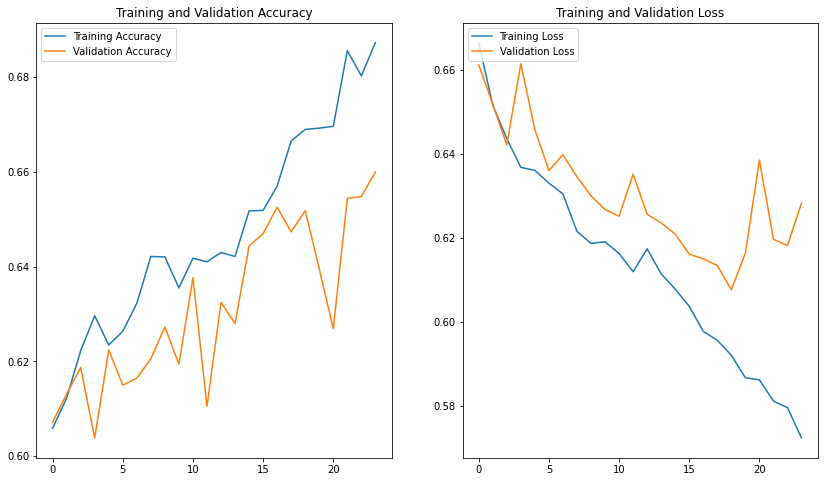

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(hist))
print(epochs_range)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

In [ ]:
with tf.device('/device:GPU:0'):
  model.evaluate_generator(test_generator, steps=len(valid_df) // batch_size, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


18/18 [==============================] - 21s 1s/step - loss: 0.7155 - accuracy: 0.5912


## ResNet

* Use Resnet50 pretrained model as our base cnn model.
* Add cnn model to TimeDistribured layer to classify 6 images in sequence.
* Add an LSTM layer in oder to memorize the image features.
* Finally a Dense layer with sigmoid activation function to classify the study.

In [ ]:
batch_size = 64
epochs = 30
IMG_HEIGHT = 96
IMG_WIDTH = 96

In [ ]:
def study_model_resnet(shape=(6, IMG_HEIGHT, IMG_WIDTH, 3), nbout=1):
    # Create our resnet with (6, 96, 96, 3) input shape
    study = Input(shape=shape)
    cnn_base = ResNet50(weights='imagenet', include_top=False, input_shape=shape[1:])
    cnn_out = GlobalAveragePooling2D()(cnn_base.output)
    cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
    cnn.trainable = False
    frames = TimeDistributed(cnn)(study)
    encoded_sequence = LSTM(256)(frames)
    hidden_layer = Dense(1024, activation="relu")(encoded_sequence)
    hidden_layer = Dropout(.5)(hidden_layer)
    outputs = Dense(nbout, activation="sigmoid")(hidden_layer)
    final_model = Model([study], outputs)
    return final_model

In [ ]:
model = study_model_resnet()
model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 6, 96, 96, 3)]    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 6, 2048)           23587712  
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               2360320   
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 1025      
Total params: 26,212,225
Trainable params: 2,624,513
Non-trainable params: 23,587,712
_______________________________________

In [ ]:
if not os.path.exists('/content/gdrive/My Drive/checkpoints'):
    os.makedirs('/content/gdrive/My Drive/checkpoints')

checkpoint = ModelCheckpoint('/content/gdrive/My Drive/checkpoints/resnet_model.hdf5',
                             monitor='val_loss', 
                             mode='min', verbose=2,
                             save_best_only=True,
                             save_weights_only=True)

with tf.device('/device:GPU:0'):
  history = model.fit(
    train_generator,
    steps_per_epoch=len(train_set) // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=len(validation_set) // batch_size,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001), checkpoint]
  )

Epoch 1/30
168/168 [==============================] - 269s 2s/step - loss: 0.6155 - accuracy: 0.6539 - val_loss: 0.5686 - val_accuracy: 0.7042

Epoch 00001: val_loss improved from inf to 0.56861, saving model to /content/gdrive/My Drive/checkpoints/resnet_model.hdf5
Epoch 2/30
168/168 [==============================] - 261s 2s/step - loss: 0.5176 - accuracy: 0.7459 - val_loss: 0.5600 - val_accuracy: 0.7258

Epoch 00002: val_loss improved from 0.56861 to 0.56004, saving model to /content/gdrive/My Drive/checkpoints/resnet_model.hdf5
Epoch 3/30
168/168 [==============================] - 265s 2s/step - loss: 0.4659 - accuracy: 0.7827 - val_loss: 0.5678 - val_accuracy: 0.7258

Epoch 00003: val_loss did not improve from 0.56004
Epoch 4/30
168/168 [==============================] - 265s 2s/step - loss: 0.4041 - accuracy: 0.8217 - val_loss: 0.5853 - val_accuracy: 0.7266

Epoch 00004: val_loss did not improve from 0.56004
Epoch 5/30
168/168 [==============================] - 263s 2s/step - los

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.590450,0.683611,0.568606,0.704241,0
1,0.510531,0.754065,0.560044,0.725818,1
2,0.450836,0.790506,0.567819,0.725818,2
3,0.388532,0.829845,0.585291,0.726562,3
4,0.316692,0.870959,0.632883,0.731027,4
5,0.238914,0.910297,0.696494,0.730283,5
6,0.168963,0.939357,0.777579,0.725818,6


Text(0.5, 1.0, 'Training and Validation Loss')

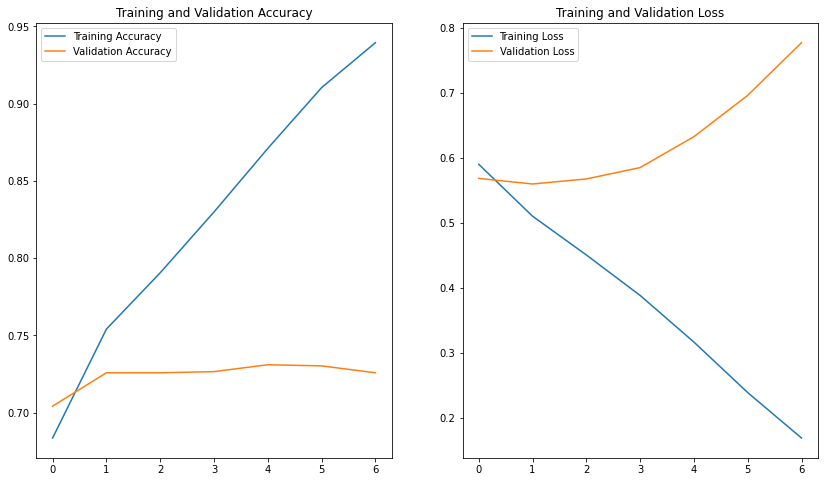

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(hist))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

In [ ]:
with tf.device('/device:GPU:0'):
  model.evaluate_generator(test_generator, steps=len(valid_df) // batch_size, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


18/18 [==============================] - 23s 1s/step - loss: 0.7300 - accuracy: 0.7374


## VGG16

* Use VGG16 pretrained model as our base cnn model.
* Add cnn model to TimeDistribured layer to classify 6 images in sequence.
* Add an LSTM layer in oder to memorize the image features.
* Finally a Dense layer with sigmoid activation function to classify the study.

In [ ]:
def study_model_vgg16(shape=(6, IMG_HEIGHT, IMG_WIDTH, 3), nbout=1):
    # Create our resnet with (6, 96, 96, 3) input shape
    study = Input(shape=shape)
    cnn_base = keras.applications.VGG16(input_shape=shape[1:], weights="imagenet", include_top=False)
    cnn_out = GlobalAveragePooling2D()(cnn_base.output)
    cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
    cnn.trainable = False
    frames = TimeDistributed(cnn)(study)
    encoded_sequence = LSTM(256)(frames)
    hidden_layer = Dense(1024, activation="relu")(encoded_sequence)
    hidden_layer = Dropout(.5)(hidden_layer)
    hidden_layer = Dense(512, activation="relu")(hidden_layer)
    hidden_layer = Dropout(.5)(hidden_layer)
    hidden_layer = Dense(64, activation="relu")(hidden_layer)
    outputs = Dense(nbout, activation="sigmoid")(hidden_layer)
    final_model = Model([study], outputs)
    return final_model

model_vgg16 = study_model_vgg16()
model_vgg16.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 96, 96, 3)]    0         
_________________________________________________________________
time_distributed (TimeDistri (None, 6, 512)            14714688  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 1024)              263168    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
____________________________________________________________

In [ ]:
if not os.path.exists('/content/gdrive/My Drive/checkpoints'):
    os.makedirs('/content/gdrive/My Drive/checkpoints')

checkpoint = ModelCheckpoint('/content/gdrive/My Drive/checkpoints/vgg16_model.hdf5',
                             monitor='val_loss', 
                             mode='min', verbose=2,
                             save_best_only=True,
                             save_weights_only=True)

with tf.device('/device:GPU:0'):
  history = model_vgg16.fit(
    train_generator,
    steps_per_epoch=len(train_set) // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=len(validation_set) // batch_size,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), checkpoint]
  )

Epoch 1/30
168/168 [==============================] - 292s 1s/step - loss: 0.6525 - accuracy: 0.6170 - val_loss: 0.6073 - val_accuracy: 0.6589

Epoch 00001: val_loss improved from inf to 0.60726, saving model to /content/gdrive/My Drive/checkpoints/vgg16_model.hdf5
Epoch 2/30
168/168 [==============================] - 231s 1s/step - loss: 0.5899 - accuracy: 0.6866 - val_loss: 0.5821 - val_accuracy: 0.7083

Epoch 00002: val_loss improved from 0.60726 to 0.58206, saving model to /content/gdrive/My Drive/checkpoints/vgg16_model.hdf5
Epoch 3/30
168/168 [==============================] - 224s 1s/step - loss: 0.5406 - accuracy: 0.7334 - val_loss: 0.5748 - val_accuracy: 0.7139

Epoch 00003: val_loss improved from 0.58206 to 0.57485, saving model to /content/gdrive/My Drive/checkpoints/vgg16_model.hdf5
Epoch 4/30
168/168 [==============================] - 225s 1s/step - loss: 0.4956 - accuracy: 0.7664 - val_loss: 0.5867 - val_accuracy: 0.7202

Epoch 00004: val_loss did not improve from 0.57485

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.631884,0.646763,0.607260,0.658854,0
1,0.578819,0.695384,0.582064,0.708333,1
2,0.527252,0.738180,0.574850,0.713914,2
3,0.478911,0.775836,0.586652,0.720238,3
4,0.422519,0.810690,0.623323,0.713170,4
5,0.353727,0.850869,0.707940,0.709077,5


Text(0.5, 1.0, 'Training and Validation Loss')

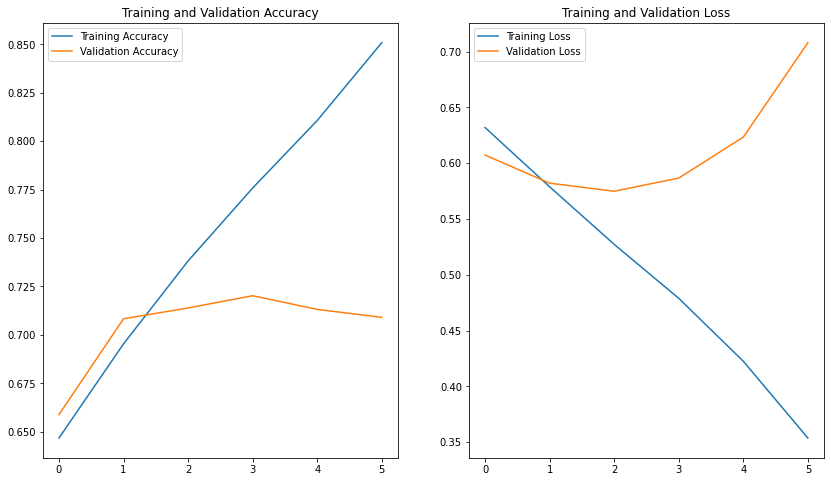

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(hist))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

In [ ]:
with tf.device('/device:GPU:0'):
  model_vgg16.evaluate_generator(test_generator, steps=len(valid_df) // batch_size, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


18/18 [==============================] - 21s 1s/step - loss: 0.7150 - accuracy: 0.7083


## Results

The Resnet50 model achieve the best score in terms of accuracy among the 3 models. The accuracy is `0.7374` in test set. The VGG16 is the second model with accuracy `0.7083` in test set. Finally the CNN from scratch achieve accuracy `0.5912` in test set which is the lowest from the 3 experiments. 